In [6]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, get_r_squared, split, to_data_matrix, scale
from sgpi.plot import *

from sgpi import model
from sgpi.learner import SGRegressionLearner

import pandas as pd
import pysgpp as sg

from scipy.sparse.linalg import LinearOperator, svds, aslinearoperator
from scipy.linalg import svd

# Artificial dataset
From SLS, two highly correlated variables, elastic net should be different than lasso here.

In [2]:
size = 100
np.random.seed(2099)
z1 = np.random.normal(size=size)
z2 = np.random.normal(size=size)
eps = np.random.normal()
y = 3 * z1 - 1.5 * z2 + 2*eps
xi = np.random.random(size=6)
x1 = z1 + xi[0]/5.0
x2 = z1 + xi[1]/5.0
x3 = z1 + xi[2]/5.0
x4 = z2 + xi[3]/5.0
x5 = z2 + xi[4]/5.0
x6 = z2 + xi[5]/5.0
df = pd.DataFrame(np.vstack((x1, x2, x3, x4, x5,x6, y))).T
df.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y']
#_, df = scale(df)
df.describe()

,x1,x2,x3,x4,x5,x6,y
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.265917,0.248874,0.197549,-0.002423,0.081831,-0.025308,1.419411
std,0.913524,0.913524,0.913524,1.055526,1.055526,1.055526,3.225223
min,-1.619544,-1.636588,-1.687913,-2.664621,-2.580367,-2.687505,-6.075552
25%,-0.345836,-0.362879,-0.414204,-0.742463,-0.658209,-0.765347,-0.588899
50%,0.197344,0.180301,0.128976,0.070366,0.154620,0.047482,1.407521
75%,0.776908,0.759865,0.708540,0.657982,0.742237,0.635098,3.616433
max,2.209136,2.192093,2.140768,2.694546,2.778800,2.671662,9.244309


In [3]:
df.corr()

,x1,x2,x3,x4,x5,x6,y
x1,1.000000,1.000000,1.000000,-0.044309,-0.044309,-0.044309,0.871483
x2,1.000000,1.000000,1.000000,-0.044309,-0.044309,-0.044309,0.871483
x3,1.000000,1.000000,1.000000,-0.044309,-0.044309,-0.044309,0.871483
x4,-0.044309,-0.044309,-0.044309,1.000000,1.000000,1.000000,-0.528560
x5,-0.044309,-0.044309,-0.044309,1.000000,1.000000,1.000000,-0.528560
x6,-0.044309,-0.044309,-0.044309,1.000000,1.000000,1.000000,-0.528560
y,0.871483,0.871483,0.871483,-0.528560,-0.528560,-0.528560,1.000000


In [7]:
#TODO extract to its own file, is from 017-RegularizationHeat!
def decode(num):
    zeros = np.zeros(len(num)) + 0.5
    return np.equal(zeros, num)

def coords_to_pred(coords):
    s = ""
    for i, c in enumerate(coords):
        if not c:
            s = s + "x{} ".format(i + 1)
    s = s.strip()
    if s == "":
        return "bias"
    else:
        s = s.replace(" ", "-")
        return s

def group_weights_raw(grid):
    storage = grid.getStorage()
    dim = storage.getDimension()

    coords = []
    for x in range(0, grid.getSize()):
        gen0 = storage.get(x)
        curCoords = []
        for i in range(0,dim):
            curCoords.append(gen0.getCoord(i))
        curCoords = np.array(curCoords)
        coords.append(curCoords)

    terms = {}
    groups = {}
    terms_nums = []
    for num, r in enumerate(coords):
        d = tuple(decode(r))
        if d not in terms:
            terms[d] = []
            groups[d] = len(groups)
        terms[d].append(num)
        terms_nums.append(groups[d])
    
    return terms

def group_weights_format(grid):
    terms = group_weights_raw(grid)
    return dict([(coords_to_pred(coords), terms[coords]) for coords in terms])

def group_list(grid):
    groups = group_weights_format(grid)
    glist = [None] * (grid.getSize())
    for group in groups:
        for i in groups[group]:
            glist[i] = group
    return glist

In [8]:
def get_Phi(grid, X_train):
    def eval_op(x, op, size):
        result_vec = sg.DataVector(size)
        x = sg.DataVector(np.array(x).flatten())
        op.mult(x, result_vec)
        return result_vec.array().copy()

    def eval_op_transpose(x, op, size):
        result_vec = sg.DataVector(size)  
        x = sg.DataVector(np.array(x).flatten())
        op.multTranspose(x, result_vec)
        return result_vec.array().copy()

    data_train = to_data_matrix(X_train)

    num_elem = X_train.shape[0]

    op = sg.createOperationMultipleEval(grid, data_train)
    matvec = lambda x: eval_op(x, op, num_elem)
    rmatvec = lambda x: eval_op_transpose(x, op, grid.getSize())

    shape = (num_elem, grid.getSize())
    linop = LinearOperator(shape, matvec, rmatvec, dtype='float64')

    Phi = linop.matmat(np.matrix(np.identity(grid.getSize())))
    return Phi

def get_max_lambda(Phi, y, num_points, l1_ratio=1.0):
    max_prod = 0
    for i in range(0, num_points):
        a = np.asarray(Phi[:,i]).flatten()
        prod = np.inner(a, y)
        max_prod = max(max_prod, prod)
    max_lambda = max_prod/(l1_ratio)
    return max_lambda

In [13]:
def calculate_weight_path(estimator, X, y, max_lambda, epsilon=0.001, num_lambdas=25,verbose=0):
    min_lambda = epsilon * max_lambda
    estimator.set_params(regularization_config__lambda_reg = max_lambda)
    estimator.fit(X, y)
    lambda_grid = np.logspace(np.log10(max_lambda), np.log10(min_lambda), num=num_lambdas)
    min_lambda, lambda_grid, min_lambda/X.shape[0]
    weights = []
    for i, lamb in enumerate(lambda_grid):
        estimator.set_params(regularization_config__lambda_reg = lamb)
        if verbose > 0:
            print "Started training estimator {}".format(i)
        estimator.fit(X, y, estimator.get_weights()) # reuse old weights
        if verbose > 0:
            print "Finished training estimator {}".format(i)
        weights.append(estimator.get_weights())
    df = pd.DataFrame(weights, index=lambda_grid)
    df = df.transpose()
    glist = group_list(grid)
    #df['group'] = glist
    #df.index = df['group'].values
    df.index=glist
    #df = df.drop('group', axis=1)
    return df

def plot_weight_path(weight_df, num_estimators = None, cmap='Paired', fig=None, ax=None):
    lambda_grid = weight_df.columns.values.astype(float)
    print 
    num_groups = len(set(weight_df.index.values))
    colors = sns.color_palette(cmap, num_groups)
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,5))
    curColor = 0
    for group, data in weight_df.groupby(weight_df.index):
        g = data
        for i in range(0,len(data)):
            d = data.values[i]
            ax.semilogx(lambda_grid, d, c=colors[curColor])
        ax.plot([], [], label=group, c=colors[curColor])
        curColor = curColor + 1
    lambdas = [np.min(lambda_grid), np.median(lambda_grid), np.max(lambda_grid)]
    if num_estimators is not None:
        lambda_names = [l/num_estimators for l in lambdas]
        ax.set_xticks(lambdas)
        ax.set_xticklabels(lambda_names)
        ax.set_xlabel("Lambda/n")
    else:
        ax.set_xlabel("Lambda")
    ax.set_ylabel("Weights")
    ax.set_xlim(left=lambda_grid[-1], right=lambda_grid[0])
    ax.legend()
    sns.despine(fig, ax)  
    return fig, ax

In [14]:
def get_estimator(grid_config, X, y, l1_ratio, reg_type):
    level = grid_config.level
    dim = X.shape[1]
    grid = sg.Grid.createModLinearGrid(dim)
    gen = grid.getGenerator()
    gen.regular(level)
    
    Phi = get_Phi(grid, X)
    max_lambda = get_max_lambda(Phi, y, grid.getSize(), l1_ratio)
    regularization_config = model.RegularizationConfig(type=reg_type, exponent_base=1, lambda_reg=max_lambda, l1_ratio=l1_ratio)
    adaptivity_config = model.AdaptivityConfig(num_refinements=0, no_points=0, treshold=0.0, percent=0.0)
    solv_type = sg.SLESolverType_FISTA
    solver_config = model.SolverConfig(type=solv_type, max_iterations=400, epsilon=0, threshold=10e-8)
    final_solver_config = solver_config
    estimator = SGRegressionLearner(grid_config, regularization_config, solver_config,
                                    final_solver_config, adaptivity_config)

    return estimator, Phi, max_lambda, grid

In [15]:
df = get_dataset('friedman1')
X_train, y_train = get_xy(df)

level = 2
l1_ratio = 1.0
reg_type = sg.RegularizationType_ElasticNet

grid_config = model.GridConfig(type=sg.GridType_ModLinear, T=0.0, level=level)

In [17]:
estimator, Phi, max_lambda, grid = get_estimator(grid_config, X_train, y_train, l1_ratio, reg_type)
df = calculate_weight_path(estimator, X_train, y_train, max_lambda, verbose=1, num_lambdas=5)

Started training estimator 0
Finished training estimator 0
Started training estimator 1
Finished training estimator 1
Started training estimator 2
Finished training estimator 2
Started training estimator 3
Finished training estimator 3
Started training estimator 4
Finished training estimator 4


In [19]:
df.to_csv('path-f1-l2-lasso', index=True)

In [23]:
df_rec = pd.read_csv('path-f1-l2-lasso', index_col=0)

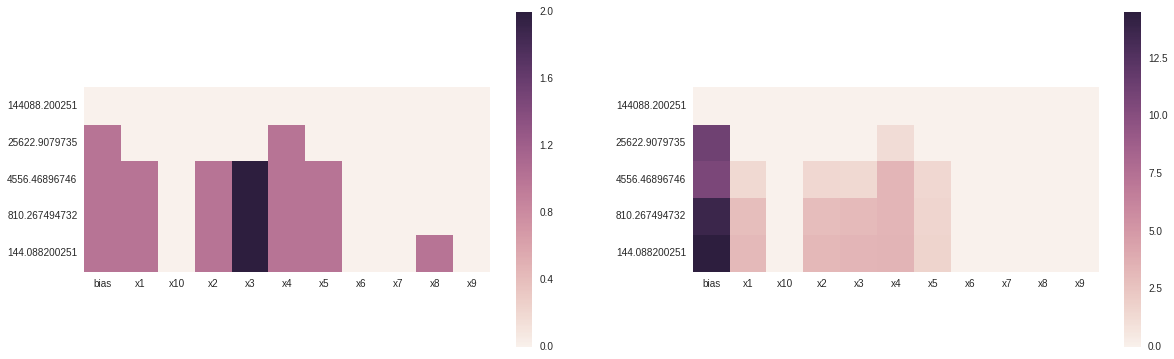

In [37]:
def get_selected_terms(group):
    return len([i for i in group if i >= 10e-9]) # todo change to == 0.0!

gb = df_rec.groupby(df_rec.index)
fix, axs = plt.subplots(1,2)
sns.heatmap(gb.aggregate(get_selected_terms).T, square=True, ax=axs[0])
sns.heatmap(gb.aggregate(lambda g : np.linalg.norm(g)).T, square=True, ax=axs[1])

(<matplotlib.figure.Figure at 0x7f2d0c4a8390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2d09b23350>)

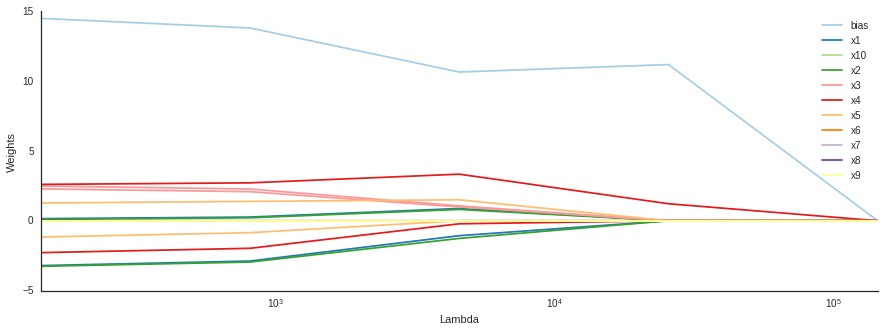

In [27]:
plot_weight_path(df_rec)

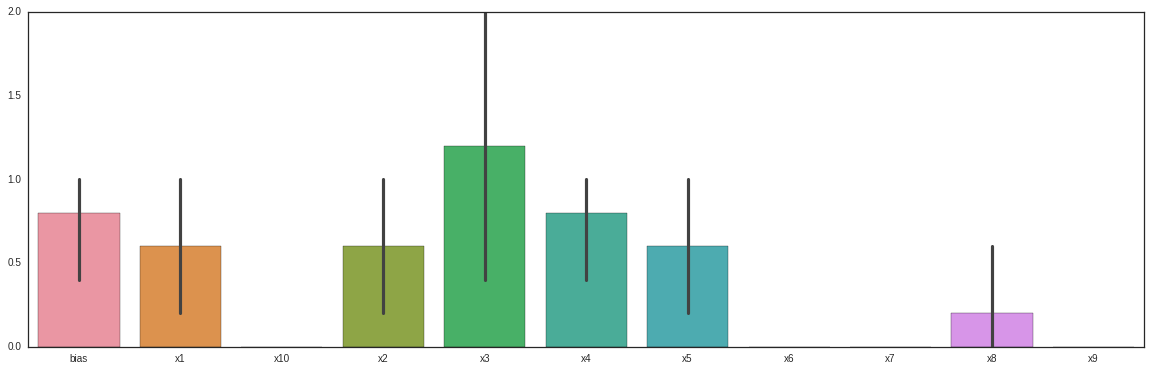

In [40]:
sns.barplot(data=gb.aggregate(get_selected_terms).T)

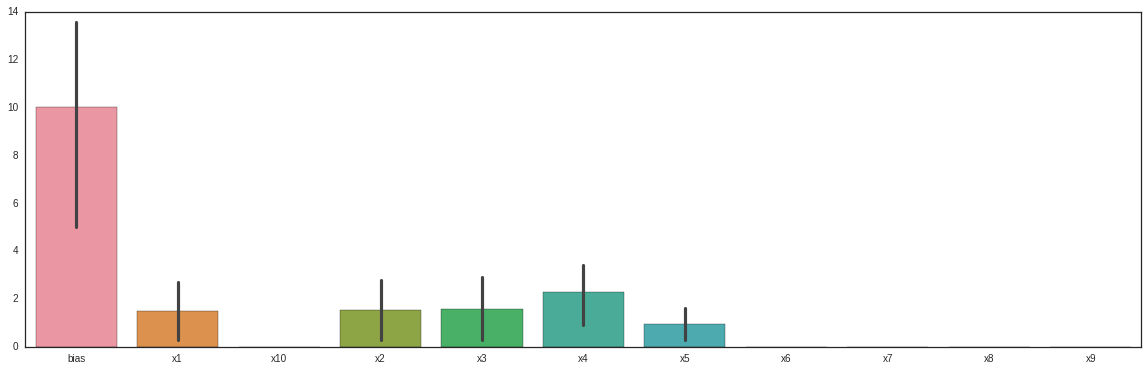

In [41]:
sns.barplot(data=gb.aggregate(lambda g : np.linalg.norm(g)).T)

In [42]:
df_rec

,144088.200251,25622.9079735,4556.46896746,810.267494732,144.088200251
bias,1.105832e-09,11.196050,10.660967,13.820141,14.508066
x1,0.000000e+00,0.000000,-1.071481,-2.888492,-3.215359
x1,0.000000e+00,0.000000,0.878723,0.262971,0.151138
x2,0.000000e+00,0.000000,-1.268033,-2.961850,-3.265104
x2,0.000000e+00,0.000000,0.810972,0.211693,0.101781
x3,0.000000e+00,0.000000,1.066310,2.276007,2.492661
x3,0.000000e+00,0.000000,0.991382,2.085210,2.281277
x4,0.000000e+00,0.000000,-0.218399,-1.975707,-2.286800
x4,0.000000e+00,1.219266,3.339038,2.717041,2.605657
x5,0.000000e+00,0.000000,0.000000,-0.854603,-1.167432
